In [143]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [144]:
features = pd.read_csv('data/raw/googleplaystore.csv')
reviews = pd.read_csv('data/raw/googleplaystore_user_reviews.csv')

In [204]:
features.dropna

features = features.drop(features.loc[features['Price'] == 'Everyone'].index)
f_copy = features.copy()
f_copy = f_copy.reset_index()
#f_copy.is_copy = False
f_copy['Price'] = f_copy['Price'].astype(str).str.replace('$', '')
f_copy['Price'] = f_copy['Price'].astype(float)


In [205]:
f_copy.loc[10473]

index                         10474
App                    Sat-Fi Voice
Category              COMMUNICATION
Rating                          3.4
Reviews                          37
Size                            14M
Installs                     1,000+
Type                           Free
Price                             0
Content Rating             Everyone
Genres                Communication
Last Updated      November 21, 2014
Current Ver                 2.2.1.5
Android Ver              2.2 and up
Name: 10473, dtype: object

In [206]:
features_final = f_copy.copy()
one = []
two = []
other = []
varies = []

for i in range(len(features_final)-1):
    if '.' in features_final.Size[i]:
     # split = features_final.Size[i].split('.')

        split = features_final.Size[i].split('.')
        first = int(split[0])
        one.append(first)

        second = split[1]
        second = int(second[:-1])

        two.append(second)
    if 'Varies with device' in features_final.Size[i]:
        varies.append(features_final.Size[i])
        
    if '.' not in features_final.Size[i] and 'with' not in features_final.Size[i]:
        hm = features_final.Size[i]
        here = int(hm[:-1])
        other.append(here)



In [207]:
len(varies)
len(one)
len(two)
len(other)
a = len(varies) + len(one) + len(other)
a

10839

In [134]:
features.Installs.unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

In [170]:
two

[7,
 8,
 6,
 1,
 7,
 5,
 2,
 0,
 0,
 1,
 6,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 0,
 9,
 6,
 6,
 7,
 6,
 4,
 7,
 5,
 0,
 4,
 9,
 9,
 9,
 4,
 1,
 9,
 2,
 5,
 8,
 0,
 7,
 7,
 9,
 9,
 6,
 2,
 1,
 7,
 4,
 4,
 9,
 1,
 4,
 2,
 2,
 9,
 9,
 6,
 1,
 9,
 5,
 2,
 4,
 8,
 0,
 9,
 1,
 7,
 7,
 7,
 9,
 8,
 9,
 5,
 0,
 3,
 2,
 1,
 1,
 3,
 1,
 9,
 2,
 3,
 5,
 1,
 5,
 5,
 6,
 2,
 8,
 5,
 6,
 0,
 5,
 6,
 8,
 9,
 2,
 4,
 3,
 3,
 7,
 1,
 1,
 3,
 1,
 7,
 7,
 8,
 7,
 8,
 6,
 6,
 1,
 0,
 3,
 3,
 2,
 4,
 0,
 1,
 8,
 3,
 2,
 3,
 7,
 3,
 3,
 7,
 7,
 8,
 5,
 1,
 3,
 6,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 9,
 9,
 0,
 4,
 0,
 0,
 2,
 7,
 5,
 5,
 8,
 8,
 9,
 8,
 6,
 4,
 1,
 9,
 0,
 9,
 5,
 2,
 8,
 5,
 1,
 5,
 4,
 7,
 0,
 9,
 9,
 9,
 4,
 8,
 5,
 9,
 7,
 9,
 6,
 6,
 7,
 2,
 9,
 0,
 9,
 3,
 0,
 0,
 0,
 0,
 6,
 0,
 8,
 0,
 9,
 5,
 8,
 0,
 2,
 3,
 9,
 4,
 5,
 8,
 0,
 0,
 7,
 4,
 9,
 1,
 9,
 0,
 5,
 8,
 7,
 7,
 9,
 5,
 5,
 5,
 9,
 3,
 3,
 2,
 1,
 1,
 0,
 9,
 4,
 5,
 9,
 0,
 9,
 8,
 8,
 3,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 6,
 9,
 5,
 0,
 3,


In [ ]:
values = ['Free','0','0+','1+','5+','10+','50+','100+','500+','1000+','5000+',
          '10000+','50000+','100000+','500000+','1000000+','5000000+','10000000+',
          '50000000+','100000000+', '500000000+', '1000000000+']

num = list(range(22))

cat_ins = features[['Category', 'Installs']].copy()

cat_ins['Installs'] = cat_ins['Installs'].astype(str).str.replace(',', '')

for i in range(len(cat_ins)):
    if cat_ins.Installs[i] in values:
        cat_ins.Installs[i] = num[values.index(cat_ins.Installs[i])]
cat_ins.head()

In [ ]:
f_copy.is_copy = false

In [ ]:
f_copy.Installs = f_copy.Installs.astype(float)

In [ ]:
f_copy.head()

In [35]:
cat_ins['Installs'] = cat_ins['Installs'].str[:-1]


Text(0.5, 1.0, '')

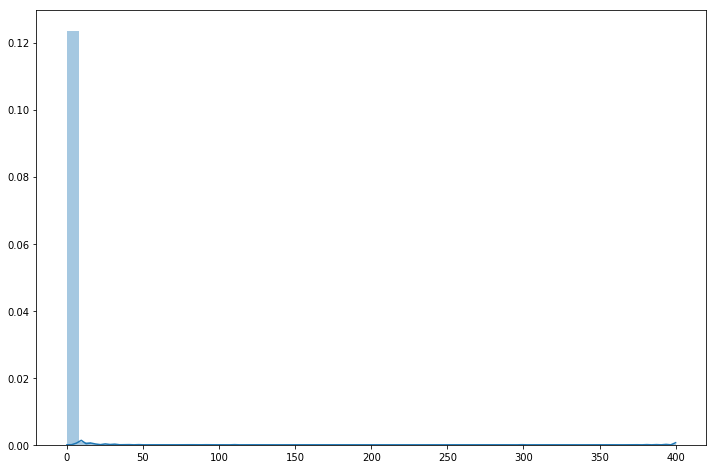

In [100]:
plt.figure(figsize=(12,8))
sns.distplot(price_ins['Price']);
plt.xlabel('')
plt.title('')

In [105]:
#cat_ins.groupby('Category').mean()
price_ins.groupby('Category').mean()

,Price
Category,
ART_AND_DESIGN,0.091846
AUTO_AND_VEHICLES,0.158471
BEAUTY,0.000000
BOOKS_AND_REFERENCE,0.518485
BUSINESS,0.402761
COMICS,0.000000
COMMUNICATION,0.214832
DATING,0.134316
EDUCATION,0.115128


In [70]:
cat_ins.dtypes

Category    object
Installs    object
dtype: object

In [102]:
price_ins.dtypes

Category     object
Price       float64
dtype: object